# Covid Sales Prediction

### 목차

### <화면 가로 확장>

In [85]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import h5py

### 2. 데이터

#### 배달의 민족 월별 정산 데이터 저장

In [67]:
try:
    os.mkdir('./Data')
    os.mkdir('./Data/BaeMin')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [68]:
for BM in range(1, len(os.listdir('./Original_Data/BaeMin'))+1):
    if BM<7:
        count_num='0'+str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 20]] # 행, 열 제한으로 필요 정보 추출
    if (BM>=7 and BM<10):
        count_num='0'+str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 21]] # 행, 열 제한으로 필요 정보 추출
    if BM>=10:
        count_num=str(BM)
        data_bm = pd.read_excel('./Original_Data/BaeMin/배달의민족-2021년'+count_num+'월_정산명세서_성정환사장님.xlsx', sheet_name='상세')
        data_bm = data_bm.iloc[3:, [0, 21]] 
    
    data_bm = data_bm.reset_index(drop=True) # 인덱스 초기화
    data_bm.to_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', header=False, encoding='cp949')
    data_bm_named=pd.read_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', names=['Date','Won'], encoding='cp949')
    data_bm_named.to_csv('./Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv', encoding='cp949')

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [69]:
# 1년 단위 파일로 병합
bm_y = pd.DataFrame()
for y in range(1, len(os.listdir('./Data/BaeMin'))+1):
    if y<=9:
        count_num='0'+str(y)
    else:
        count_num=str(y)
        
    file = './Data/BaeMin/배달의 민족_2021년_'+count_num+'월_수익정산.csv'
    bm_m= pd.read_csv(file, encoding='cp949')
    bm_y = pd.concat([bm_y, bm_m])
    
bm_y = bm_y.drop([bm_y.columns[0]], axis=1)
bm_y = bm_y.reset_index(drop=True)
bm_y.to_csv('./Data/배달의 민족_2021년_수익정산.csv', encoding='cp949')

# 중간에 0이 있는데 코로나 때문에 0이 된게 아니라면 이상치 처리를 해야함.

In [70]:
data_bm_sum=pd.DataFrame(columns=['Date','Won'])
data_bm=pd.read_csv('./Data/배달의 민족_2021년_수익정산.csv', encoding='cp949')
data_bm = data_bm.drop([data_bm.columns[0]], axis=1)

for D in range(len(data_bm)-1):
    y=data_bm['Date'][D][0:4]
    m=data_bm['Date'][D][5:7]
    d=data_bm['Date'][D][8:10]
    YMD=y+m+d
    if(data_bm['Date'][D]==data_bm['Date'][D+1]):
        won=int(data_bm['Won'][D]+data_bm['Won'][D+1])
        new_data=[YMD, won]
        data_bm_sum.loc[D]=new_data
    else:
        new_data=[YMD, int(data_bm['Won'][D])]
        data_bm_sum.loc[D]=new_data

for D in range(len(data_bm_sum)):
    try:
        if(data_bm_sum['Date'][D]==data_bm_sum['Date'][D+1]):
            data_bm_sum=data_bm_sum.drop(D+1, axis=0)

    except KeyError:
        pass
    
print(data_bm_sum)
data_bm_sum = data_bm_sum.reset_index(drop=True)
data_bm_sum.to_csv('./Data/배달의 민족_2021년_수익정산_동일날짜합.csv', encoding='cp949')

         Date      Won
0    20210104   249789
2    20210105   211252
3    20210106   152762
5    20210107  1310714
7    20210108   252126
..        ...      ...
418  20211123    48750
420  20211124   123086
422  20211125   572818
424  20211125     4835
425  20211126    98345

[260 rows x 2 columns]


#### 서울시 기상 정보 저장

In [71]:
data_weather = pd.read_excel('./Original_Data/OBS_ASOS_DD_20211123223955.xlsx')
data_weather = data_weather.iloc[:, [2,3,5,6]]
data_weather.insert(2, '강수여부', 1) # 컬럼 새로 생성 후 우선은 다 비오는 경우인 '1'로 입력

for num in range(len(data_weather)):
    rain_values = data_weather.iloc[num, [3]].values[0] # 강수량 컬럼의 정보를 읽어옴
    if (str(rain_values)=='nan' or float(rain_values)==0.0):
        data_weather['강수여부'][num]=0 # 맑은 날은 0으로 값 변경
        data_weather['일강수량(mm)'][num]=0
        
data_weather = data_weather.reset_index(drop=True) # 인덱스 초기화
data_weather.to_csv('./Data/2021_서울_기상정보.csv', encoding='cp949')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/2957362069.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather['강수여부'][num]=0 # 맑은 날은 0으로 값 변경
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/2957362069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weather['일강수량(mm)'][num]=0


#### 전국 Covid 정보 저장

In [72]:
data_covid = pd.read_excel('./Original_Data/코로나 현황.xlsx')
start_date=int(data_covid.loc[data_covid['날짜'] == 20201231].index[0])
data_covid = data_covid.iloc[start_date:, [0,1,4]]
data_covid = data_covid.reset_index(drop=True) # 인덱스 초기화
data_covid.to_csv('./Data/2021_KOREA_Covid.csv', encoding='cp949')

In [73]:
data_covid

,날짜,확진자수(양성),검사수
0,20201231.0,60726.0,4213872.0
1,20210101.0,61753.0,4269308.0
2,20210102.0,62573.0,4302790.0
3,20210103.0,63230.0,4340830.0
4,20210104.0,64250.0,4376600.0
...,...,...,...
323,20211119.0,409099.0,15848464.0
324,20211120.0,412305.0,15851670.0
325,20211121.0,415425.0,15854790.0
326,20211122.0,418252.0,15857617.0


#### 거리두기 규제 및 집합 인원수, 증가 추이 컬럼 추가

In [74]:
data_covid=pd.read_csv('./Data/2021_KOREA_Covid.csv', encoding='cp949')

data_covid['확진자 증가량']=np.NaN
data_covid['검사수 증가량']=np.NaN
data_covid['18시 전 규제 인원수']=np.NaN
data_covid['18시 후 규제 인원수']=np.NaN
data_covid['영업 제한 시각']=np.NaN

covid_rules={20201231: [5,5,21], 20210121: [5,5,21], 20210215: [5,5,22], 20210701: [9,9,24], 20210712: [5,3,24], 20211018: [9,9,24], 20211101: [10,10,27]}
# 시간 제한이 사라진 이후는 24시 이후 영업의 의미를 담기 위해 27로 설정.

for D in range (len(data_covid)-1):
    date=int(data_covid['날짜'][D])
    data_covid['확진자 증가량'][D+1] = int(data_covid['확진자수(양성)'][D+1]-data_covid['확진자수(양성)'][D])
    data_covid['검사수 증가량'][D+1] = float(data_covid['검사수'][D+1]-data_covid['검사수'][D])
    try:
        rules=covid_rules[date]
    except KeyError:
        rules=rules
    
    data_covid['18시 전 규제 인원수'][D+1]=rules[0]
    data_covid['18시 후 규제 인원수'][D+1]=rules[1]
    data_covid['영업 제한 시각'][D+1]=rules[2]
    
data_covid=data_covid.drop(0)
data_covid=data_covid.astype(int)
data_covid = data_covid.drop([data_covid.columns[0]], axis=1)
print(data_covid)
data_covid.to_csv('./Data/2021_KOREA_Covid+.csv', encoding='cp949')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/3661655148.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_covid['확진자 증가량'][D+1] = int(data_covid['확진자수(양성)'][D+1]-data_covid['확진자수(양성)'][D])
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/3661655148.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_covid['검사수 증가량'][D+1] = float(data_covid['검사수'][D+1]-data_covid['검사수'][D])
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/3661655148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

           날짜  확진자수(양성)       검사수  확진자 증가량  검사수 증가량  18시 전 규제 인원수  \
1    20210101     61753   4269308     1027    55436             5   
2    20210102     62573   4302790      820    33482             5   
3    20210103     63230   4340830      657    38040             5   
4    20210104     64250   4376600     1020    35770             5   
5    20210105     64964   4439352      714    62752             5   
..        ...       ...       ...      ...      ...           ...   
323  20211119    409099  15848464     3034     3034            10   
324  20211120    412305  15851670     3206     3206            10   
325  20211121    415425  15854790     3120     3120            10   
326  20211122    418252  15857617     2827     2827            10   
327  20211123    420950  15860315     2698     2698            10   

     18시 후 규제 인원수  영업 제한 시각  
1               5        21  
2               5        21  
3               5        21  
4               5        21  
5               5    

In [75]:
Data_bm=pd.read_csv('./Data/배달의 민족_2021년_수익정산_동일날짜합.csv', encoding='cp949')
Data_weather=pd.read_csv('./Data/2021_서울_기상정보.csv', encoding='cp949')
Data_covid=pd.read_csv('./Data/2021_KOREA_Covid+.csv', encoding='cp949')

Data_weather2=Data_weather.iloc[:,[2,3,4,5]]
Data_bm2=Data_bm.iloc[:, [1,2]]

In [76]:
Data_C_W = pd.concat([Data_covid, Data_weather2],axis=1)
Data_C_W=Data_C_W[:-1] # 날씨 데이터는 11/23 데이터가 없기 때문에 맨 마지막 row 삭제

In [77]:
Data_C_W['Won']=0

C1=0
C2=0
      
while(True):
    try:
        if(int(Data_C_W['날짜'][C1])==int(Data_bm2['Date'][C2])):
            Data_C_W['Won'][C1]=Data_bm2['Won'][C2]
            C1+=1
            C2+=1

        if(int(Data_C_W['날짜'][C1])>int(Data_bm2['Date'][C2])):
            C2+=1

        if(int(Data_C_W['날짜'][C1])<int(Data_bm2['Date'][C2])):
            C1+=1
            
    except:
        break
        
Data_C_W_B=Data_C_W
Data_C_W_B = Data_C_W_B.drop([Data_C_W_B.columns[0]], axis=1)
Data_C_W_B.to_csv('./Data/2021_Data_Combined.csv', encoding='cp949')

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_16280/2695586111.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_C_W['Won'][C1]=Data_bm2['Won'][C2]


#### 최종 데이터 Import

In [88]:
Data_Combined=pd.read_csv('./Data/2021_Data_Combined.csv', encoding='cp949')
Data_Combined = Data_Combined.drop([Data_Combined.columns[0]], axis=1)
Data_Combined

,날짜,확진자수(양성),검사수,확진자 증가량,검사수 증가량,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,20210101,61753,4269308,1027,55436,5,5,21,-4.2,0.0,0.0,2.0,0
1,20210102,62573,4302790,820,33482,5,5,21,-5.0,0.0,0.0,2.6,0
2,20210103,63230,4340830,657,38040,5,5,21,-5.6,0.0,0.0,2.0,0
3,20210104,64250,4376600,1020,35770,5,5,21,-3.5,0.0,0.0,1.7,249789
4,20210105,64964,4439352,714,62752,5,5,21,-5.5,0.0,0.0,2.9,211252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,20211118,406065,15845430,3290,3290,10,10,27,11.9,0.0,0.0,2.4,322402
322,20211119,409099,15848464,3034,3034,10,10,27,12.9,0.0,0.0,1.9,55371
323,20211120,412305,15851670,3206,3206,10,10,27,10.4,0.0,0.0,1.6,0
324,20211121,415425,15854790,3120,3120,10,10,27,10.4,1.0,5.9,1.9,0


In [79]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [80]:
def Graph(name, x, y, y_name):
    font_head = {'color': '#ff7f0e', 'weight': 'bold', 'size': 20}
    font_body = {'color': '#ff7f0e', 'weight': 'bold', 'size': 15}
    plt.figure(figsize=(30,10))
    plt.plot(x, y, '.-', linewidth=1, color='#ff7f0e')
    plt.tick_params(axis='x', colors='k', size=10, labelsize=15)
    plt.tick_params(axis='y', colors='k', size=10, labelsize=15)
    plt.xlabel("날짜", labelpad=15, fontdict=font_body)
    plt.ylabel(y_name, labelpad=15, fontdict=font_body)
    plt.title(name, fontdict=font_head, pad=20)
    plt.margins(x=0.02)
    plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 325], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'END'])
    plt.savefig('./Result/Graph/'+str(name)+'.png')
    plt.show

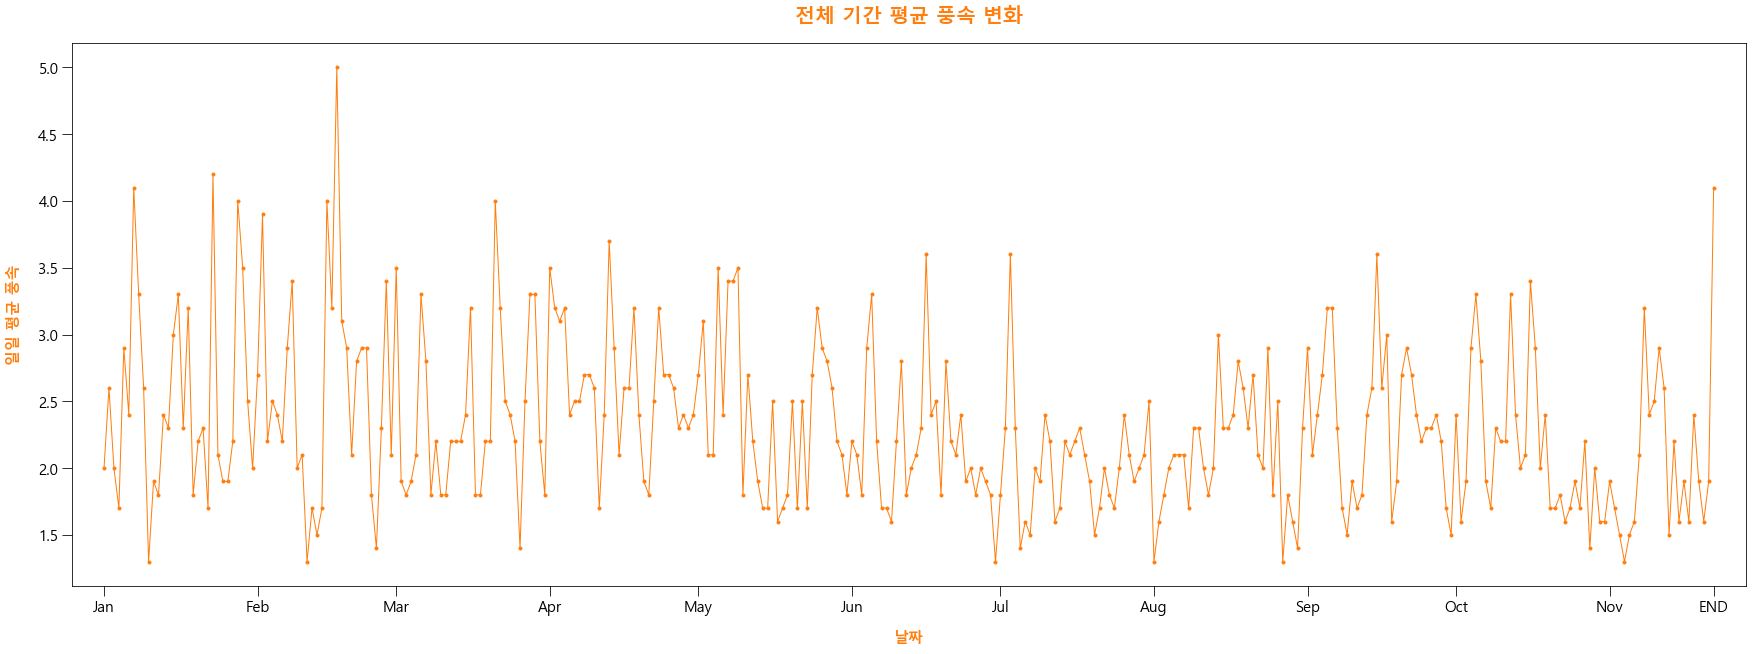

In [84]:
Graph('전체 기간 평균 풍속 변화', Data_Combined['Unnamed: 0'], Data_Combined['평균 풍속(m/s)'], '일일 평균 풍속')